In [1]:
import sys
import os

current_dir = os.getcwd()
project_path = os.path.join(current_dir, '..')
sys.path.append(project_path)

In [2]:
%matplotlib ipympl

import matplotlib.pyplot as plt
import numpy as np
import loss
from mlnn.engine import MLNNEngine
from mlnn.callback import MLNNCallback
from mlnn.optimize import MLNNSteepestDescent, MLNNBFGS

from sklearn.datasets import load_wine
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

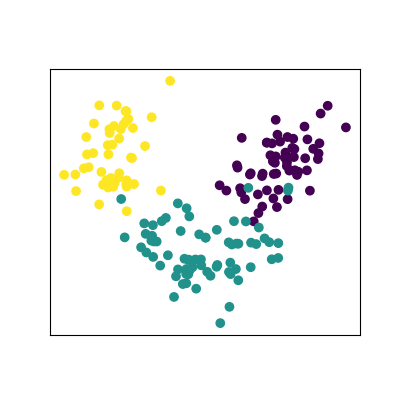

In [3]:
data = load_wine()

X_original = np.array(data['data'])
Y_original = np.array(data['target'], dtype=int)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(X_original, Y_original):
    X_train, Y_train = X_original[train_index, :], Y_original[train_index]
    X_test, Y_test = X_original[test_index, :], Y_original[test_index]

X_train, Y_train = X_original, Y_original
X_test, Y_test = X_original, Y_original

pipeline = Pipeline([('std_scaler', StandardScaler())])
X_train_scaled = pipeline.fit_transform(X_train)
X_test_scaled = pipeline.transform(X_test)

pca = PCA(n_components=2)
X_train_2D = pca.fit_transform(X_train_scaled)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.resizable = False
ax.scatter(X_train_2D[:, 0], X_train_2D[:, 1], c=Y_train)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_aspect('equal', adjustable='box')
plt.show()

In [4]:
knn = KNeighborsClassifier(3)
knn.fit(X_train_scaled, Y_train)
Y_test_pred = knn.predict(X_test_scaled)
accuracy = accuracy_score(Y_test, Y_test_pred)
print(f"accuracy = {accuracy: .3f}")

accuracy =  0.961


In [5]:
rbf = False

kernel = 'linear'
#kernel = 'nonlinear'

#a_mode = 'full'
#a_mode = 'diagonal'
a_mode = 'decomposed'

e_mode = 'single'
#e_mode = 'multiple'

#i_mode = 'zero'
#i_mode = 'random'
#i_mode = 'centered'
#i_mode = 'identity'
i_mode = 'pca'

keep_a_psd = False
keep_a_centered = False
keep_e_positive = False
reduce_derivative_matrix = False
check_array_equal = False

n_components = 2

r = 1
s = 0
l = 1
q = 1
inner_loss = loss.SmoothReLU(.5)
outer_loss = loss.SmoothReLU(.5)
#outer_loss = None

optimize_method = 'fixed'
initialization = i_mode
min_delta_F = 1e-6
max_steps = 10
max_time = 1000
fixed_arguments = 'AE'
max_arg_steps = 5

line_search_method = 'backtracking'
use_prev_f = False
alpha_0 = 1e-3
armijo = 1e-6
wolfe = .9
max_ls_iterations = 20

In [6]:
X = X_train_scaled
Y = Y_train

sigma2 = 10 ** 1.12
P = X @ X.T
D = P.diagonal().reshape(-1, 1) + P.diagonal().reshape(1, -1) - 2 * P
G = np.exp(D / (-2 * sigma2))

In [7]:
if kernel == 'linear':
    B = X
elif kernel == 'nonlinear':
    if rbf:
        B = G
    else:
        B = G

if kernel == 'linear':
    C = None
elif kernel == 'nonlinear':
    #C = B
    C = None

In [8]:
mlnn_params = {
    'r': r,
    's': s,
    'l': l,
    'q': q,
    'inner_loss': inner_loss,
    'outer_loss': outer_loss,
    'kernel': kernel,
    'a_mode': a_mode,
    'e_mode': e_mode,
    'keep_a_psd': keep_a_psd,
    'keep_a_centered': keep_a_centered,
    'keep_e_positive': keep_e_positive,
    'reduce_derivative_matrix': reduce_derivative_matrix,
    'check_array_equal': check_array_equal,
}

optimize_params = {
    'optimize_method': optimize_method,
    'initialization': initialization,
    'min_delta_F': min_delta_F,
    'max_steps': max_steps,
    'max_time': max_time,
    'fixed_arguments': fixed_arguments,
    'max_arg_steps': max_arg_steps,
}

line_search_params = {
    'line_search_method': line_search_method,
    'use_prev_f': use_prev_f,
    'alpha_0': alpha_0,
    'armijo': armijo,
    'wolfe': wolfe,
    'max_ls_iterations': max_ls_iterations,
}

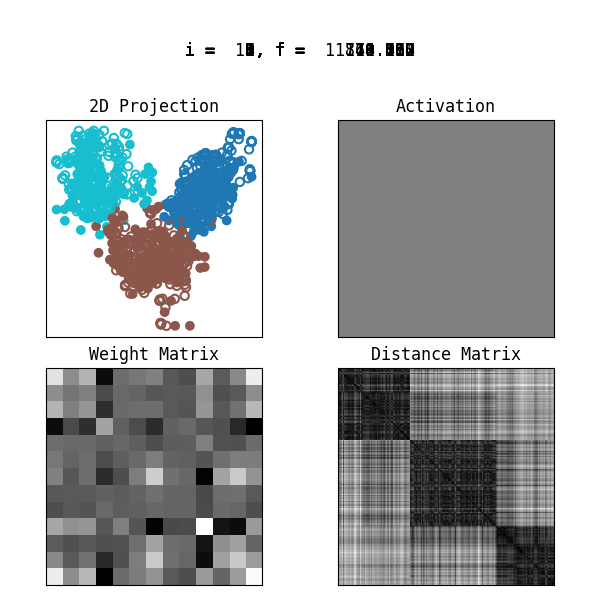

In [9]:
mlnn = MLNNEngine(B, Y, C, mlnn_params)
#callback = MLNNCallback(print_stats=True)
callback = MLNNCallback(animate='all')
optimizer = MLNNSteepestDescent(mlnn, callback=callback, n_components=n_components,
                                optimize_params=optimize_params,
                                line_search_params=line_search_params)
optimizer.minimize(verbose=False)
#optimizer.report()

In [10]:
line_search_params['line_search_method'] = 'strong_wolfe'
mlnn = MLNNEngine(B, Y, C, mlnn_params)
callback = MLNNCallback(print_stats=True)
optimizer = MLNNSteepestDescent(mlnn, callback=callback, n_components=n_components,
                                optimize_params=optimize_params,
                                line_search_params=line_search_params)
optimizer.minimize(verbose=False)
optimizer.report()

step  args iter   alpha       phi      delta_F       F          R          S          L        mean_E   actv_rows actv_cols actv_data
    0  -    -       -          -          -       1.178e+04  5.000e-01  0.000e+00  1.178e+04  1.000e+00       141       178       178
    1  AE     5  1.859e-05 -2.080e+09  1.102e+04  7.576e+02  4.748e-02  0.000e+00  7.575e+02  1.124e+00        29       178       178
    2  AE     4  2.104e-05 -7.776e+07  6.239e+02  1.336e+02  7.113e-02  0.000e+00  1.336e+02  1.092e+00         8       178       178
    3  AE     2  3.995e-05 -4.164e+06  9.321e+01  4.043e+01  5.957e-02  0.000e+00  4.037e+01  1.094e+00         5       178       178
    4  AE     1  2.195e-04 -7.579e+05  6.518e-01  3.977e+01  4.850e-02  0.000e+00  3.973e+01  1.095e+00         6       178       178
    5  AE     2  6.241e-05 -1.632e+06  2.216e+01  1.761e+01  5.682e-02  0.000e+00  1.755e+01  1.085e+00         4       178       178
    6  AE     1  6.620e-05 -1.539e+06  1.335e+00  1.627e+01  5

In [11]:
mlnn = MLNNEngine(B, Y, C, mlnn_params)
callback = MLNNCallback(print_stats=True)
optimizer = MLNNBFGS(mlnn, callback=callback, n_components=n_components,
                     optimize_params=optimize_params,
                     line_search_params=line_search_params)
optimizer.minimize(verbose=False)
optimizer.report()

step       delta_F       F          R          S          L        mean_E   actv_rows actv_cols actv_data
    0         -       1.178e+04  5.000e-01  0.000e+00  1.178e+04  1.000e+00       141       178       178
    1      8.758e+03  3.022e+03  3.890e-02  0.000e+00  3.022e+03  1.146e+00        91       178       178
    2      2.641e+03  3.817e+02  1.112e-01  0.000e+00  3.816e+02  1.070e+00        12       178       178
    3      1.182e+02  2.635e+02  1.019e-01  0.000e+00  2.634e+02  1.070e+00         9       178       178
    4      1.594e+02  1.041e+02  8.466e-02  0.000e+00  1.040e+02  1.063e+00         8       178       178
    5      7.653e+01  2.757e+01  8.343e-02  0.000e+00  2.748e+01  1.061e+00         3       178       178
    6      1.159e+01  1.598e+01  8.367e-02  0.000e+00  1.590e+01  1.058e+00         2       173       173
    7      1.519e+01  7.912e-01  8.488e-02  0.000e+00  7.064e-01  1.055e+00         3       173       173
    8      7.061e-01  8.514e-02  8.514e-02  0.